# Kamera kalibráció az OpenCV függvénykönyvtár segítségével

Ebben a leírásban nem egy kész programot fogunk használni, hanem megnézzük, hogy hogyan tudunk kalibrációs programrészletet készíteni az OpenCV (3.4) függvénykönyvtár segítségével. 

1. **Inicializálás:** Inicializálunk egy rácsot ```real_world_points``` néven, amelynek annyi sora és oszlopa lesz, ahány sora és oszlopa van a belső rácsnak, a Z koordiántája 0 minden pontnak, a rács méretét meg lehet adni a valóságszerint is, de lehet egységnyi, mivel a kalibráció csak egy skálafaktor erejéig meghatározott.
2. **Sarokpontok meghatározása:** Minden képen megkeressük a sakktábla-minta sarokpontjait az OpenCV ```findChessboardCorners()``` függvényével, ezeket letároljuk az imgpoints tömbbe. Ha megtaláltuk a rácspontokat (ez függ a képtől), akkor ```cornerSubPix()``` függvénnyel finomítjuk azok koordinátáit. 
3. **Kalibráció:** A kalibrációt a ```calibrateCamera()``` függvénnyel hajtjuk végre, amelynek meg kell adni a valós világbeli pontokat, a képen talált sarokpontokat és a kép méretét. A függvény visszaadja a kamera mátrixot, a forgatás és eltolás vektorokat, valamint a disztorziós együtthatókat. A kameramátrixot finomíthatjuk a ```getOptimalNewCameraMatrix()``` függvénnyel. 
4. **Visszavetítési hiba számítása:** Számítsuk ki a visszavetítési hibát a  ```projectPoints``` függvénnyel! 
5. **Kamera póz meghatárzása:** A kameramátrix és a disztorziós együtthatók segítségével meg tudjuk határozni a sakktábla-mintát tartalmazó sík helyzetét. Ehhez hívjuk meg a ```solvePnP()``` függvényt. A képre rajzolt koordináta-tengelyeket a generált ábrák mutatják. Ezeket "pose_" prefixel le is mentjük minden kép esetén.

Tekintsük az alábbi példakódot ([Forráskód letöltése](kamera_kalibracio/python_code/calibration.py))

reading images:
kamera_kalibracio/python_code/images6Mpx/Chessboard_01.jpg
True
kamera_kalibracio/python_code/images6Mpx/Chessboard_02.jpg
True
kamera_kalibracio/python_code/images6Mpx/Chessboard_03.jpg
True
kamera_kalibracio/python_code/images6Mpx/Chessboard_10.jpg
True
kamera_kalibracio/python_code/images6Mpx/Chessboard_11.jpg
True
kamera_kalibracio/python_code/images6Mpx/Chessboard_12.jpg
True
kamera_kalibracio/python_code/images6Mpx/Chessboard_14.jpg
True
kamera_kalibracio/python_code/images6Mpx/Chessboard_15.jpg
True
kamera_kalibracio/python_code/images6Mpx/Chessboard_16.jpg
True
kamera_kalibracio/python_code/images6Mpx/Chessboard_17.jpg
True
kamera_kalibracio/python_code/images6Mpx/Chessboard_18.jpg
True
camera matrix = [[2.55541234e+03 0.00000000e+00 1.62257968e+03]
 [0.00000000e+00 2.55328025e+03 9.30904865e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
focalLength = 3.9145409692148116
fovx = 65.12772173762033
fovy = 39.55000258654634
aspectRatio = 0.9991656548648029
new

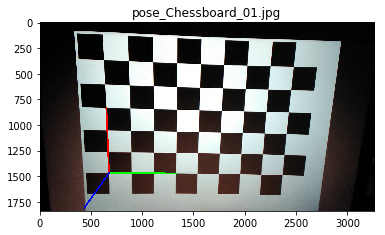

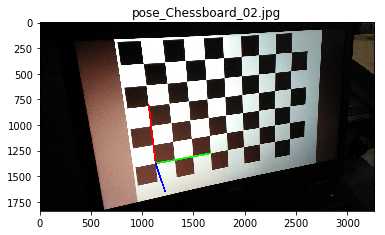

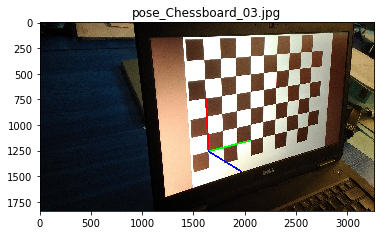

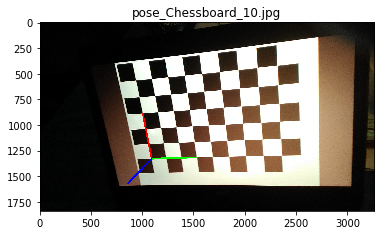

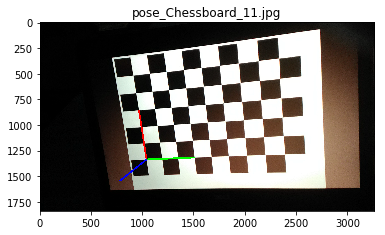

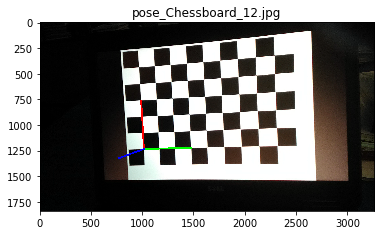

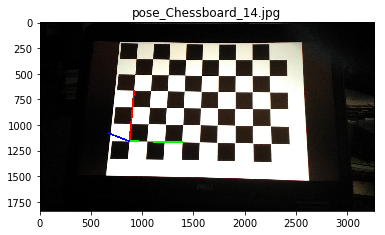

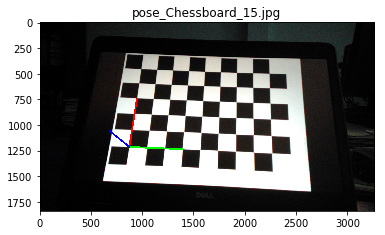

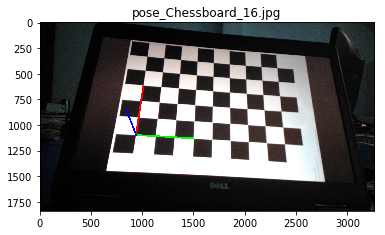

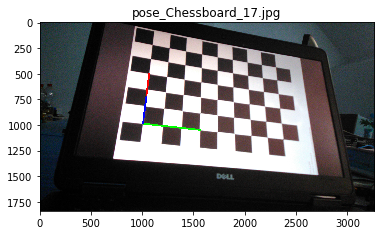

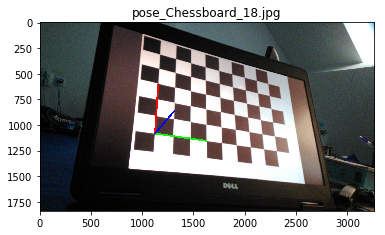

In [4]:
## A forráskód az OpenCV függvénykönyvtár hivatalos tutorialja alapján 
## készült. 
## Dr. Németh Gábor 
## Szegedi Tudományegyetem

from matplotlib import pyplot as plt
import numpy as np
import cv2
import glob
import os
%matplotlib inline

#megállási feltétel a subpixel kereséshez
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

GRIDSIZE = 22   ## 22 mm egy négyzet a mintán
SENSOR_WIDTH = 5  ## asus zenfone live ~ 5mm, canon eos 1000d = 22.2mm
SENSOR_HEIGHT=14.8   # asus zenfone live ~ 5mm, canon_eos_1000d = 14.8mm


#valós világbeli pontok
real_world_points = np.zeros( (6*9, 3), np.float32) 
#print(real_world_points)

# egy 6x9-os minta lesz, amely tuladonképpen egy rács, a Z koordináta mindenhol 0
real_world_points[:, :2] = np.mgrid[0:6*GRIDSIZE:GRIDSIZE,0:9*GRIDSIZE:GRIDSIZE].T.reshape(-1,2) 
#print(real_world_points)

# ezekben a tömbökben tároljuk a pontokat minden fényképhez
objpoints = [] # a 3D valós világbeli pontoknak
imgpoints = [] # a képen detektált pontoknak

images = glob.glob('kamera_kalibracio/python_code/images6Mpx/Chessboard*.jpg')
img = cv2.imread('kamera_kalibracio/python_code/images6Mpx/Chessboard_01.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # a képet szürkeárnyalatossá konvertáljuk
imgsize = gray.shape[::-1] 
## -----------------
## képek beolvasása
## -----------------
# végighaladunk a képeken
print('reading images:'); 
for fname in images:
	print(fname)
	img = cv2.imread(fname)
	gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # a képet szürkeárnyalatossá konvertáljuk
	if imgsize == None:
		imgsize = gray.shape[::-1]
    
	## Megkeressük a sarokpontokat a sakktáblán
	ret, corners = cv2.findChessboardCorners(gray, (6,9), None);
	
	## ha találtunk (ret == True), akkor 
	## az objpoints tömbhöz hozzáadjuk a valós világbeli pontrácsot
	## az imgpointshoz pedig a képen detektált sarokpontokat
	print(ret)
	if ret == True:
		objpoints.append(real_world_points)
		corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
		imgpoints.append(corners2)
		
		# kirajzoljuk a képre a megtalált sarokpontokat 
		##print('rajzolunk')
		img = cv2.drawChessboardCorners(img, (6,9), corners2, ret)
		cv2.imwrite('corners_' + os.path.basename(fname), img )


## --------------------
## Kalibráció 
## --------------------
# ret:   visszatérési érték
# mtx:   kamera mátrix
# dist:  disztorziós együtthatók
# rvecs: forgatás mátrix paraméterek
# tvecs: eltolás vektor paraméterek
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,(imgsize[0], imgsize[1]), None, None)

fovx, fovy, focalLength, principalPoint, aspectRatio = cv2.calibrationMatrixValues(mtx, imgsize, SENSOR_WIDTH,SENSOR_HEIGHT)
## kb 5mm-es apertúra mellett kapom meg a valódi értékeket

#print('Calibration result: ' + ret)
#if ret == True:
print('camera matrix = '+ str(mtx))
print('focalLength = ' + str(focalLength) )
print('fovx = ' + str(fovx) )
print('fovy = ' + str(fovy) )
print('aspectRatio = ' + str(aspectRatio) )
	
## ----------------------------
## Lencsetorzítás korrekciója
## ----------------------------
img = cv2.imread('kamera_kalibracio/python_code/images6Mpx/Chessboard_01.jpg');
h,w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

print('new camera matrix = ' + str(newcameramtx))

dst = cv2.undistort(img, mtx, dist, None, None)
#cv2.imshow(dst)
# kép levágása
#x,y,w,h, = roi
#dst = dst[y:y+h, x:x+w]
cv2.imwrite('calibresults.png', dst);


# ------------------------------
# Visszavetítési hiba számítása 
# ------------------------------
mean_error = 0
for i in range(len(objpoints)):
	imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
	error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
	mean_error += error
	
print('mean error: ' + str(mean_error/len(real_world_points)))

# -------------------------------
# Külső paraméterek meghatározása 
# -------------------------------

## ---- segédfüggvény a tengelyrajzoláshoz ----
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 15)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 15)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 15)
    return img
# ---------------------------------------------

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:6,0:9].T.reshape(-1,2)
axis = np.float32([[3*GRIDSIZE,0,0], [0,3*GRIDSIZE,0], [0,0,-3*GRIDSIZE]]).reshape(-1,3)
for fname in images:
	img = cv2.imread(fname)
	gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	ret, corners = cv2.findChessboardCorners(gray, (6,9), None)
	
	if ret == True:
		corners2 = cv2.cornerSubPix(gray, corners, (11,111), (-1,-1), criteria)
		
		ret, rvecs, tvecs = cv2.solvePnP(real_world_points, corners2, mtx, dist)
		
		imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)
		img = draw(img, corners2, imgpts)
		cv2.imwrite('pose_' + os.path.basename(fname), img )
		plt.imshow(img);
		plt.title('pose_' + os.path.basename(fname))
		plt.show()
	



# Feladatok 

1. Hajtsuk végre a kamera kalibrációt az OpenCV függvénykönyvtár függvényeinek segítségével!
2. A kalibráció során lekérdeztük a fókusztávolságot is a ```getCameraMatrix()``` függvényel. Vessük össze a fényképezőgép hardverleírását a kapott értékekkel! Mi történik, ha változtatunk a szenzorméreten? 
3. Töltsük le a [Python kódot](kamera_kalibracio/python_code/calibration.py) és futtassuk le az [images_eos_1000](kamera_kalibration/python_code/images_eos_1000) könyvtárban lévő képeken. A **SENSOR_WIDTH** és **SENSOR_HEIGHT** értékeket állítsuk át a típusnak megfelelően (az értékek a forráskód kommentárjában találhatók). ***Figyelem!*** *A program a nagyfelbontású (10Mpx) képek miatt sokáig fut!*  
4. Készítsünk saját képeket mobiltelefonunkkal vagy fényképezőgépünkkel. Az egyszerűség kedvéért nevezzük át a képeket úgy, hogy a fájlnevek *Chessboard_XY.jpg* alakúak legyenek, ahol *XY* a sorszámot jelöli. Adjuk meg ezeknek a képeknek a könyvtárát a [Python kódban](kamera_kalibracio/python_code/calibration.py) az **IMAGES_DIR** változóban. Futtassuk le a kalibrációs programot és vessük össze az kamera paramétereket (gyűjtótávolság, látószög) a hardver specifikációval. Futás közben figyeljük meg azt is, hogy minden képeket fel tudott-e használni a program a kalibrációhoz (a futás közben a fájlnevek alatt megjelenő TRUE és FALSE szövegek jelölik a sikerességet)!  
